# Reinforced learning, työllistyminen ja Suomen sosiaaliturva

Tässä tehdään laskelmat artikkelia varten. Käytössä on gym-ympäristö _unemployment-v1_ , johon on toteutettu yksityiskohtaisempi työttömyysturvamalli.

In [1]:
# for Colab, install fin_benefits and unemployment-gym from Github
#!pip install -q git+https://github.com/ajtanskanen/benefits.git  
#!pip install -q git+https://github.com/ajtanskanen/econogym.git
#!pip install -q git+https://github.com/ajtanskanen/lifecycle-rl.git

# and then restart kernel
  
  # For a specific version:
#!pip install tensorflow==1.15
#!pip install stable-baselines==2.8
  
# restart kernel after running pip's

Then load all modules and set parameters for simulations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lifecycle_rl import Lifecycle

%matplotlib inline
%pylab inline

# varoitukset piiloon (Stable baseline ei ole vielä Tensorflow 2.0-yhteensopiva, ja Tensorflow 1.15 valittaa paljon)
# ei taida toimia piilottaminen
import warnings
warnings.filterwarnings('ignore')

# parameters for the simulation
# episode = 51 / 205 timesteps (1y/3m timestep)
pop_size=1_000 # size of the population to be simulated
size1=2_000_000 #0_000 # number of timesteps in phase 1 training (callback not used)
size2=600_000 #0_000 # number of timesteps in phase 2 training (callback is used to save the best results)
size3=1_000_000 # number of timesteps in phase 1 training (callback not used) for policy changes
batch1=1 # size of minibatch in phase 1 as number of episodes
batch2=9_00  # size of minibatch in phase 1 as number of episodes
callback_minsteps=batch2 # how many episodes callback needs 
deterministic=True # use deterministic prediction (True) or probabilitic prediction (False)
mortality=False # include mortality in computations
randomness=False # include externally given, random state-transitions (parental leaves, disability, lay-offs) 
pinkslip=True # include lay-offs at 5 percent level each year
rlmodel='acktr' # use ACKTR algorithm
perusmalli='best/malli_perus2'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Populating the interactive namespace from numpy and matplotlib


# Nykymalli 

Lasketaan työllisyysasteet nykymallissa.

No mortality included
Parameters of lifecycle:
timestep 0.25
gamma 0.9793703613355593 (0.9200000000000003 per anno)
min_age 20
max_age 70
min_retirementage 63.5
max_retirementage 68.5
ansiopvraha_kesto300 None
ansiopvraha_kesto400 None
ansiopvraha_toe None
perustulo False
karenssi_kesto 0.25
mortality False
randomness False
deterministic True

include_putki None
step 0.25

train...
phase 1
acktr acktr
batch 1 learning rate 0.25 scaled 0.25




Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






training...








---------------------------------
| explained_variance | 0.976    |
| fps                | 837      |
| nupdates           | 1        |
| policy_entropy     | 0.631    |
| policy_loss        | 0.199    |
| total_timesteps    | 0        |
| value_loss         | 0.296    |
--------------------

---------------------------------
| explained_variance | 0.875    |
| fps                | 1273     |
| nupdates           | 40       |
| policy_entropy     | 0.748    |
| policy_loss        | -1.77    |
| total_timesteps    | 95511    |
| value_loss         | 6.2      |
---------------------------------
---------------------------------
| explained_variance | 0.958    |
| fps                | 1259     |
| nupdates           | 50       |
| policy_entropy     | 0.745    |
| policy_loss        | 0.296    |
| total_timesteps    | 120001   |
| value_loss         | 0.72     |
---------------------------------
---------------------------------
| explained_variance | 0.964    |
| fps                | 1255     |
| nupdates           | 60       |
| policy_entropy     | 0.748    |
| policy_loss        | 1.04     |
| total_timesteps    | 144491   |
| value_loss         | 2.54     |
---------------------------------
---------------------------------
| explained_variance | 0.952    |
| fps         

---------------------------------
| explained_variance | 0.957    |
| fps                | 1253     |
| nupdates           | 310      |
| policy_entropy     | 0.777    |
| policy_loss        | -0.426   |
| total_timesteps    | 756741   |
| value_loss         | 0.743    |
---------------------------------
---------------------------------
| explained_variance | 0.956    |
| fps                | 1246     |
| nupdates           | 320      |
| policy_entropy     | 0.773    |
| policy_loss        | 0.698    |
| total_timesteps    | 781231   |
| value_loss         | 1.19     |
---------------------------------
---------------------------------
| explained_variance | 0.949    |
| fps                | 1243     |
| nupdates           | 330      |
| policy_entropy     | 0.751    |
| policy_loss        | 0.0634   |
| total_timesteps    | 805721   |
| value_loss         | 0.802    |
---------------------------------
---------------------------------
| explained_variance | 0.928    |
| fps         

---------------------------------
| explained_variance | 0.97     |
| fps                | 1226     |
| nupdates           | 580      |
| policy_entropy     | 0.906    |
| policy_loss        | 0.0994   |
| total_timesteps    | 1417971  |
| value_loss         | 0.388    |
---------------------------------
---------------------------------
| explained_variance | 0.978    |
| fps                | 1219     |
| nupdates           | 590      |
| policy_entropy     | 0.905    |
| policy_loss        | 0.409    |
| total_timesteps    | 1442461  |
| value_loss         | 0.551    |
---------------------------------
---------------------------------
| explained_variance | 0.972    |
| fps                | 1210     |
| nupdates           | 600      |
| policy_entropy     | 0.888    |
| policy_loss        | -0.774   |
| total_timesteps    | 1466951  |
| value_loss         | 1.03     |
---------------------------------
---------------------------------
| explained_variance | 0.945    |
| fps         

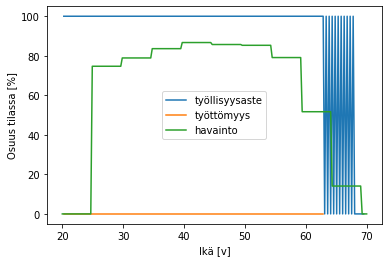

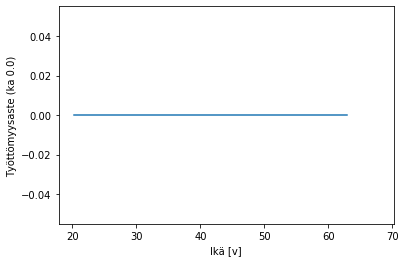

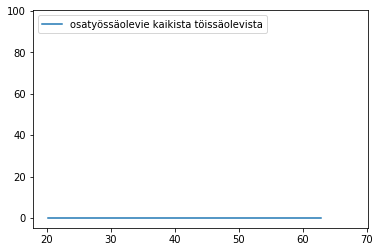

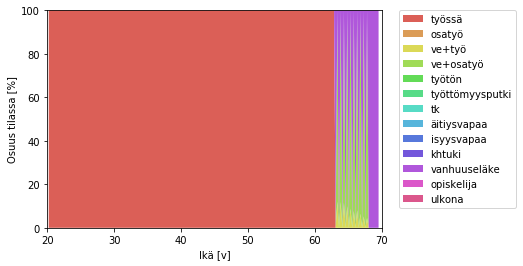

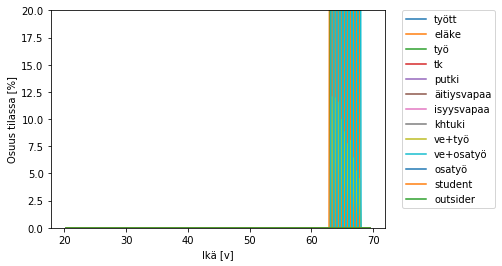

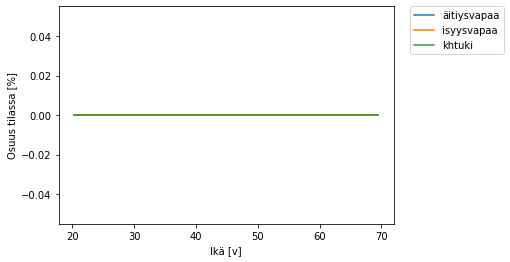

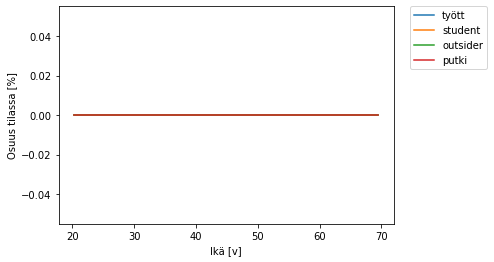

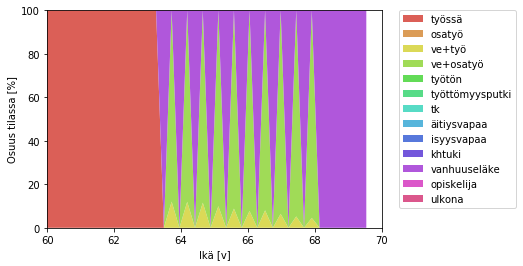

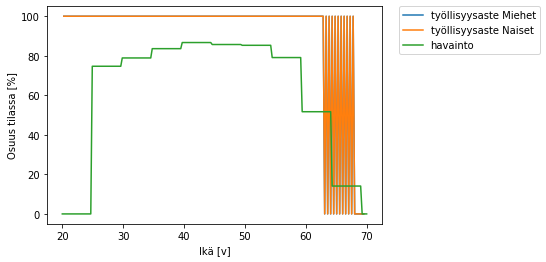

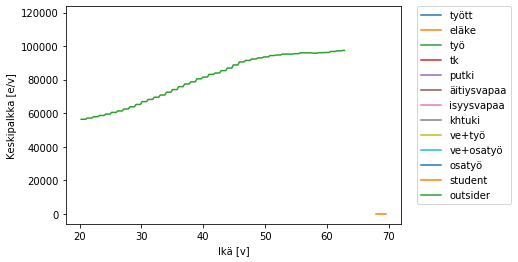

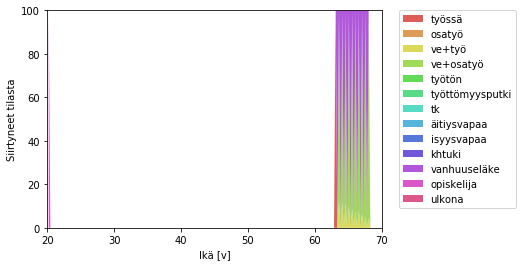

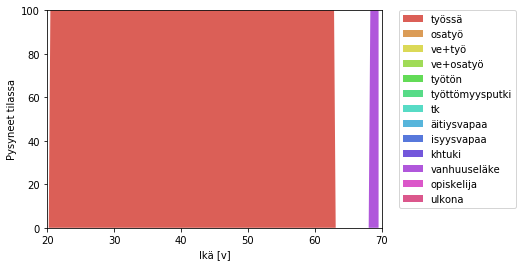

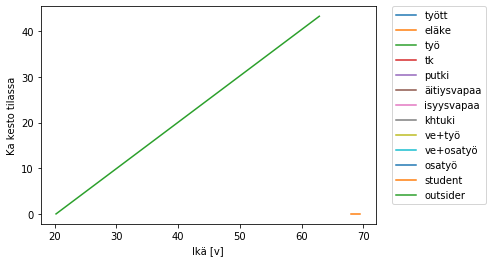

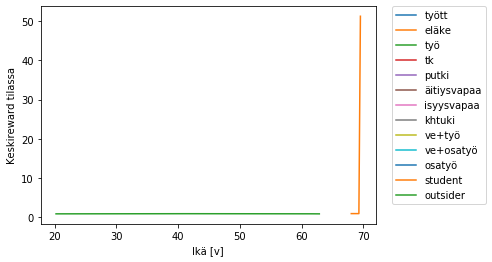

No handles with labels found to put in legend.


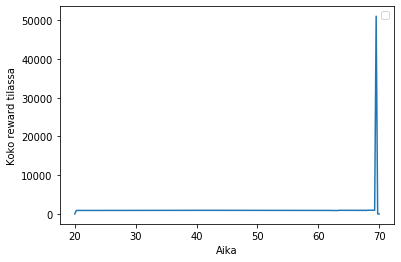

Yhteensä reward 235.3024424326283


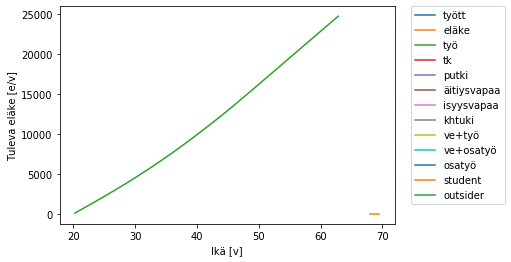

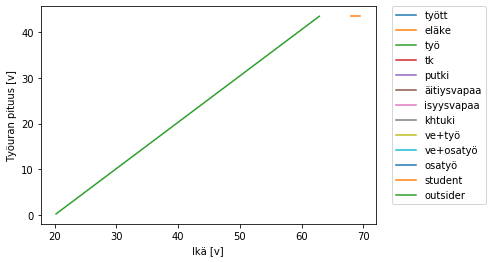

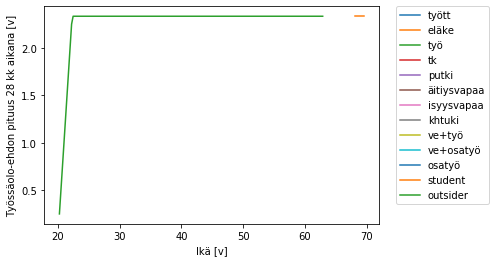

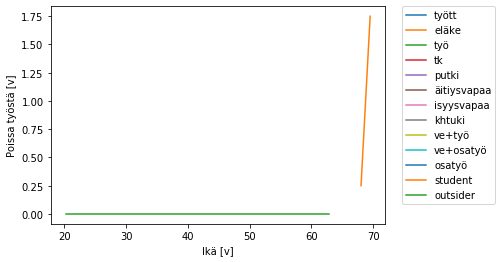

In [3]:
cc1=Lifecycle(env='unemployment-v1',minimal=False,mortality=mortality,perustulo=False,
              deterministic=deterministic,randomness=randomness,pinkslip=pinkslip)
if True:
    cc1.explain()
    cc1.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,
                    save=perusmalli,plot=True,cont=True,start_from=perusmalli,results='results/perus_results2',
                    callback_minsteps=callback_minsteps,rlmodel=rlmodel,twostage=False)
cc1.render(load='results/perus_results2')

# Porrastettu työttömyysturva



In [ ]:
cc2_porras=Lifecycle(env='unemploymentSteps-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness)
cc2_porras.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,save='best/malli_steps',plot=True,
                results='results/steps_results',start_from=perusmalli,cont=True,
                callback_minsteps=callback_minsteps)
cc2_porras.render(load='results/steps_results')


No mortality included
train...
phase 1


In [ ]:
cc2_porras.compare_with(cc1)

# Työttömyysputken poisto

Työttömyysputkelle meneminen on usein hyvin suosittua elinkaarimalleissa. Tarkastellaan millainen työllisyysvaikutus on putken poistamisella.

In [ ]:
cc1_putki=Lifecycle(env='unemployment-v1',minimal=False,include_putki=False,mortality=mortality,
                    perustulo=False,randomness=randomness)
cc1_putki.run_results(debug=False,steps1=size1,steps2=size2,pop=pop_size,deterministic=deterministic,
                      train=True,predict=True,batch1=batch1,batch2=batch2,save='best/malli_putki',
                      plot=True,results='results/putki_results',start_from=perusmalli,cont=True,
                      callback_minsteps=callback_minsteps)
cc1_putki.render(load='results/putki_results')
cc1_putki.compare_with(cc1)                    

In [ ]:
cc1_putki.render(load='results/putki_results')
cc1_putki.compare_with(cc1) 

# EK:n malli

Lasketaan vertailukelpoiset työllisyysasteet EK:n ehdottamalla mallilla. Mallissa on toteuttu muutoksia ansiosidonnaiseen työttömyysturvaan, asumistukeen, toimeentulotukeen ja verotukseen.

In [ ]:
cc2=Lifecycle(env='unemploymentEK-v1',minimal=False,mortality=mortality,perustulo=False,
              randomness=randomness)
cc2.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                train=True,predict=True,batch1=batch1,batch2=batch2,save='best/malli_ek',plot=True,
                results='results/ek_results',start_from=perusmalli,cont=True,
                callback_minsteps=callback_minsteps)
cc2.render(load='results/ek_results')
cc2.load_sim(load='results/ek_results')

In [ ]:
cc2.compare_with(cc1)
#print(cc1.episodestats.empstate/cc1.n_pop,cc2.episodestats.empstate/cc2.n_pop)
#cc2.episodestats.load_sim('results/ek_res__best')
#cc2.episodestats.render()

# Verifiointi

Ajetaan sama simulaatio kaksi kertaa ja tarkastetaan että tulokset ovat sama. Tässä ideana on varmistaa, että satunnaisuus ei sotke tulosten arviointia.

# Työssäoloehdon pituus 12 kk

Entä jos työssäoloehto olisikin 12 kuukautta pitkä nykyisen 6 kuukauden sijaan?

In [ ]:
cc1_toe=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_toe=1.0,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_toe.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=False,predict=True,batch1=batch1,batch2=batch2,save='best/best_12kk',plot=True,
                    results='results/12kk_results',start_from=perusmalli,cont=True,
                callback_minsteps=callback_minsteps)
cc1_toe.render(load='results/12kk_results')
cc1_toe.compare_with(cc1)

# Ansiosidonnaisen päivärahan lyhennys 50 pv

Tarkastellaan, miten työllisyyteen vaikuttaisi ansiosidonnaisen päivärahan lyhentäminen 50 päivällä. Tällöin alle kolmen vuoden työhistorialla ansiosidonnaisen päivärahan enimmäiskesto olisi 250 pv ja pidemmällä työhistorialla enimmäiskesto olisi 350 pv.

In [ ]:
cc1_350=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=250,ansiopvraha_kesto400=350,
                  mortality=mortality,perustulo=False,randomness=randomness)
cc1_350.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=False,predict=True,batch1=batch1,batch2=batch2,save='best/malli_50pv',plot=True,
                    results='results/50pv_results',start_from=perusmalli,cont=True,
                    callback_minsteps=callback_minsteps)
cc1_350.render(load='results/50pv_results')
cc1_350.compare_with(cc1)

# Perustulo

In [ ]:
cc1_pt=Lifecycle(env='unemployment-v1',minimal=False,perustulo=True,mortality=mortality,
                 randomness=randomness)
cc1_pt.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                   train=True,predict=True,batch1=batch1,batch2=batch2,save='best/malli_pt',plot=True,
                   results='results/perustulo_results',start_from=perusmalli,cont=True,
                callback_minsteps=callback_minsteps)
cc1_pt.render(load='results/perustulo_results')
cc1_pt.compare_with(cc1)

# 300 vs 400 päivän kesto ansiosidonnaisessa

Mikä on alle kolmen vuoden työhistorian lyhyemmän (300 pv) ansiosidonnaisen päivärahan enimmäiskeston vaikutus työllisyyteen? Kokeillaan miten työllisyyteen vaikuttaisi sen pidentäminen 400 päivään.

In [ ]:
cc1_400=Lifecycle(env='unemployment-v1',minimal=False,ansiopvraha_kesto300=400,mortality=mortality,
                  perustulo=False,randomness=randomness)
cc1_400.run_results(debug=False,steps1=size3,steps2=size2,pop=pop_size,deterministic=deterministic,
                    train=True,predict=True,batch1=batch1,batch2=batch2,save='best/malli_300pv',plot=True,
                    results='results/300pv_results',start_from=perusmalli,cont=True,
                callback_minsteps=callback_minsteps)
cc1_400.render(load='results/300pv_results')
cc1_400.compare_with(cc1)